In [1]:
%reset -f

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from functions.load_data import load_data_cat
from functions.preprocessing.get_generator import get_generator
from functions.network.UNet import UNet

import numpy as np
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
import pickle
import time
import functions.visualize as v
import matplotlib.pyplot as plt
from functions.visualization import plot_heights_and_classes
import os
import glob
import argparse

# Parse in parameter
#import argparse
#
#parser = argparse.ArgumentParser()
#
#parser.add_argument('--flag', type=str, default='als', help="Type of point cloud to train on. [Default='als']")
#parser.add_argument('--learning_rate', type=float, default=0.01, help="Learning Rate for Optimizer [default=0.01]")
#parser.add_argument('--optimizer', type=str, default='Adam', help="Optimizing function for training [default='Adam']")
#
#FLAGS = parser.parse_args()
#
#learning_rate = FLAGS.learning_rate
#opt = FLAGS.optimizer
#
#if __name__ == '__main__':
#    
#    print('Eingegebene learning_rate: {}'.format(learning_rate))
#    
#    if opt == 'Adam':
#        print('Eingegebene Optimierungsfunktion: Adam')
#    elif opt == 'SGD':
#        print('Eingegebene Optimierungsfunktion: SGD')
#
#        
#    
#    dir_logs = '/media/politz/Daten/test/lr_' + str(learning_rate) + '_opt_' + opt
#    if not os.path.exists(dir_logs):
#        os.makedirs(dir_logs)

# Parameter
flag = 'als'

split_ratio = 0.7
tvt = True
batch_size = 32
opt = 'Adam'
learning_rate = 0.001
momentum = 0.9
dropout = 0.8
batchnorm = True
epochs = 50 
target_names = ['no data', 'ground', 'building', 'non-ground']

seed = 0
np.random.seed(seed) 

# more parameter depending on flag value
if flag == 'dim':
    traintest = 'dim/'
    test = 'als/'
#    first_dataset = 'xy_dim_cat3.npy'
#    second_dataset = 'xy_full_cat3.npy' 
    first_dataset = 'xy_dim_with_background.npy'
    second_dataset = 'xy_als_with_background.npy'
    dir_in_traintest = './cache/alsdim16_30cm/'
    dir_in_test = './cache/alsdim16_30cm/'
#    dir_in_test = './cache/pgrangelabel_data/'
elif flag == 'als':
    traintest = 'als/'
    test = 'dim/'
#    first_dataset = 'xy_full_cat3.npy'
#    second_dataset = 'xy_dim_cat3.npy'
#    dir_in_traintest = './cache/pgrangelabel_data/'
    first_dataset = 'xy_als_with_background.npy'
    second_dataset = 'xy_dim_with_background.npy'
    dir_in_traintest = './cache/alsdim16_30cm/'
    dir_in_test = './cache/alsdim16_30cm/'
    

# create folder

dir_logs = './logs/' + flag + '/'
if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)
    print('Created {}.'.format(dir_logs))

dir_out_traintest = dir_logs + traintest
if not os.path.exists(dir_out_traintest):
    os.makedirs(dir_out_traintest)
    print('Created {}.'.format(dir_out_traintest))

dir_out_test = dir_logs + test
if not os.path.exists(dir_out_test):
    os.makedirs(dir_out_test)
    print('Created {}.'.format(dir_out_test)) 
    
dir_weights = dir_logs + '/weights/'
if not os.path.exists(dir_weights):
    os.makedirs(dir_weights)
    print('Created {}.'.format(dir_weights)) 
    


#load all data and get generator
x_train, y_train, x_eval, y_eval, x_test, y_test = load_data_cat(dir_in_traintest, 
                                                                 filename = first_dataset, 
                                                                 shuffle = True, 
                                                                 seed = seed, 
                                                                 split_ratio = split_ratio, 
                                                                 tvt = tvt)
print(x_train.shape, x_eval.shape, x_test.shape)
print('loading in data done.')
xy_gen_train = get_generator(x_train, y_train, batch_size, seed)
print('creating generators done.')

# get model
img_shape = x_train.shape
model = UNet(img_shape[1:4], out_ch = 4, depth = 2, dropout = dropout, batchnorm = batchnorm)

#optim_func = SGD(lr=learning_rate, momentum=momentum, decay=0.0, nesterov=True)
if opt == 'Adam':
    optim_func = Adam(lr=learning_rate)
else: 
    optim_func = SGD(lr=learning_rate, momentum=momentum, nesterov = True)
    
model.compile(loss='categorical_crossentropy', optimizer = optim_func, metrics=['acc'])
print('creating model done.')
#model.summary()  

# Callbacks
checkpoints = ModelCheckpoint(dir_weights + 'weights_{epoch:02d}_{val_loss:.4f}.hdf5', save_best_only=True)
tensorboard = TensorBoard(log_dir = dir_logs, 
                          histogram_freq = 1,
                          batch_size = batch_size)
csvlogger = CSVLogger(dir_logs + 'logfile.log', append=True)

print('creating callbacks done.')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(1400, 100, 100, 3) (300, 100, 100, 3) (300, 100, 100, 3)
loading in data done.
creating generators done.
creating model done.
creating callbacks done.


In [4]:
# Training

print('Start training.')
start = time.time()
history = model.fit_generator(xy_gen_train, 
                    steps_per_epoch = int(len(x_train)/batch_size), 
                    epochs = epochs, 
                    callbacks = [checkpoints, tensorboard, csvlogger],
                    validation_data = (x_eval, y_eval), 
                    initial_epoch= 0)

print("Training reached epoch's end. It took: {} min.".format((time.time()-start)/60))
model.save(dir_weights + 'final_w.h5')

with open(dir_logs + 'trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)   
print('weights and history saved.')

Start training.
Epoch 1/50
43/43 [==============================] - 23s 538ms/step - loss: 0.8237 - acc: 0.6321 - val_loss: 3.4523 - val_acc: 0.2020
Epoch 2/50
43/43 [==============================] - 21s 484ms/step - loss: 0.5707 - acc: 0.7434 - val_loss: 0.7685 - val_acc: 0.6933
Epoch 3/50
43/43 [==============================] - 19s 449ms/step - loss: 0.4329 - acc: 0.8124 - val_loss: 0.6481 - val_acc: 0.7602
Epoch 4/50
43/43 [==============================] - 19s 452ms/step - loss: 0.3734 - acc: 0.8480 - val_loss: 0.7385 - val_acc: 0.8185
Epoch 5/50
43/43 [==============================] - 19s 446ms/step - loss: 0.3456 - acc: 0.8674 - val_loss: 0.4503 - val_acc: 0.8628
Epoch 6/50
43/43 [==============================] - 19s 449ms/step - loss: 0.2540 - acc: 0.9079 - val_loss: 0.6000 - val_acc: 0.7589
Epoch 7/50
43/43 [==============================] - 19s 447ms/step - loss: 0.2239 - acc: 0.9188 - val_loss: 1.7208 - val_acc: 0.4761
Epoch 8/50
43/43 [==============================] - 2

Best weights: ./logs/als//weights/weights_33_0.1282.hdf5

Report for Testing:

             precision    recall  f1-score   support

    no data       1.00      1.00      1.00    275945
     ground       0.96      0.99      0.98   1808322
   building       0.80      0.75      0.77     93162
 non-ground       0.95      0.91      0.93    822571

avg / total       0.96      0.96      0.96   3000000

Accuracy Score: 0.959515
Confusion matrix, without normalization
[[ 274937     965       0      43]
 [    371 1785593     510   21848]
 [      1    7925   69775   15461]
 [     63   57110   17158  748240]]


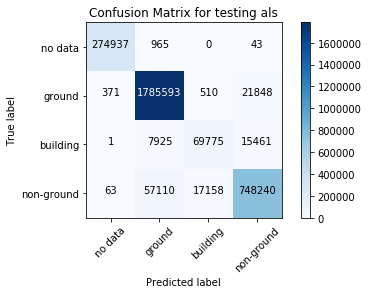

In [3]:
# Testing mit ALS - Daten

# get best weights
list_of_files = glob.glob(dir_weights + 'weights_*.hdf5') # * means all if need specific format then *.csv
best_weights = max(list_of_files, key=os.path.getctime)
print('Best weights: {}\n'.format(best_weights))

# load best weights
model.load_weights(best_weights)

# print Confusion Matrix
y_pred = model.predict(x_test)
y_pred_shaped = np.reshape(np.argmax(y_pred, axis = -1), (-1,))
y_true_shaped = np.reshape(np.argmax(y_test, axis = -1), (-1,))

np.save(dir_logs + 'y_pred_' + flag + '.npy', y_pred)
np.save(dir_logs + 'y_true_' + flag + '.npy', y_test)
np.save(dir_logs + 'heights_' + flag + '.npy', x_test)

# show conf matrix for test data set
v.visualize_all_results(y_true_shaped, y_pred_shaped, target_names, normalize=False, title='Confusion Matrix for testing ' + flag)

Best weights: ./logs/als//weights/weights_33_0.1282.hdf5

Report for Testing:



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 4, does not match size of target_names, 3
  .format(len(labels), len(target_names))


             precision    recall  f1-score   support

     ground       1.00      1.00      1.00    275945
   building       0.96      0.99      0.98   1808322
 non-ground       0.80      0.75      0.77     93162

avg / total       0.96      0.96      0.96   3000000

Accuracy Score: 0.959515
Confusion matrix, without normalization
[[ 274937     965       0      43]
 [    371 1785593     510   21848]
 [      1    7925   69775   15461]
 [     63   57110   17158  748240]]


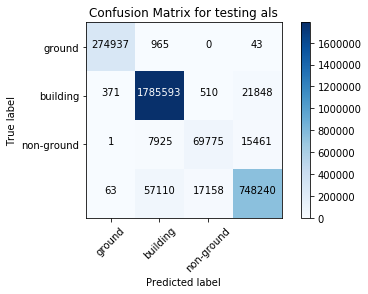

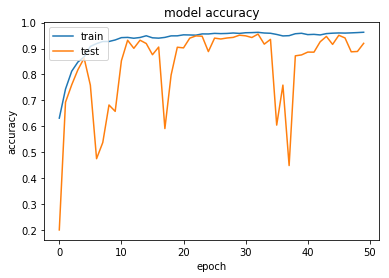

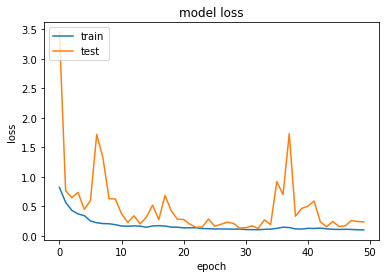

In [5]:
# summarize history for accuracy and loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:
# save als image results
index = [str(i) for i in range(x_test.shape[0])]
plot_heights_and_classes.plot_heights_and_classes(dir_out_traintest, index, x_test, y_pred, y_test, background = True)


1/300 test images saved.
31/300 test images saved.
61/300 test images saved.
91/300 test images saved.
121/300 test images saved.
151/300 test images saved.
181/300 test images saved.
211/300 test images saved.
241/300 test images saved.
271/300 test images saved.


(1400, 100, 100, 3) (300, 100, 100, 3) (300, 100, 100, 3)
(1400, 100, 100, 4) (300, 100, 100, 4) (300, 100, 100, 4)
loading in data done.
Report for Testing:

             precision    recall  f1-score   support

    no data       0.68      0.05      0.09    275945
     ground       0.82      0.86      0.84   1808322
   building       0.18      0.76      0.29     93162
 non-ground       0.57      0.48      0.52    822571

avg / total       0.72      0.68      0.67   3000000

Accuracy Score: 0.6764113333333334
Confusion matrix, without normalization
[[  13269  152730   29498   80448]
 [   3564 1551815   48587  204356]
 [    210    9486   71114   12352]
 [   2491  178967  248077  393036]]


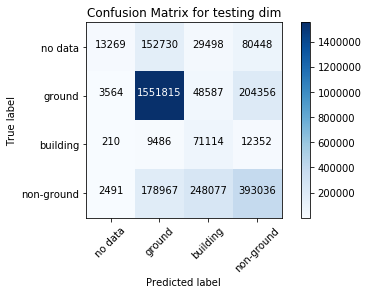

In [5]:
# Testing with second dataset
np.random.seed(seed)

#load all data and get generator
x_train, y_train, x_eval, y_eval, x_test, y_test = load_data_cat(dir_in_test, 
                                                                 filename = second_dataset, 
                                                                 shuffle = True, 
                                                                 seed = seed, 
                                                                 split_ratio=split_ratio, 
                                                                 tvt=tvt)
print(x_train.shape, x_eval.shape, x_test.shape)
print(y_train.shape, y_eval.shape, y_test.shape)
print('loading in data done.')

# load best weights
# model.load_weights(best_weights)

y_pred = model.predict(x_test)
y_pred_shaped = np.reshape(np.argmax(y_pred, axis = -1), (-1,))
y_true_shaped = np.reshape(np.argmax(y_test, axis = -1), (-1,))

if flag == 'dim':
    second_flag = 'als'
elif flag == 'als':
    second_flag = 'dim'

np.save(dir_logs + 'y_pred_' + second_flag + '.npy', y_pred)
np.save(dir_logs + 'y_true_' + second_flag + '.npy', y_test)
np.save(dir_logs + 'heights_' + second_flag + '.npy', x_test)

target_names = ['no data', 'ground', 'building', 'non-ground']
v.visualize_all_results(y_true_shaped, y_pred_shaped, target_names, normalize=False, title='Confusion Matrix for testing ' + second_flag)

In [6]:
# save als image results
plot_heights_and_classes.plot_heights_and_classes(dir_out_test, index, x_test, y_pred, y_test, background = True)

1/300 test images saved.
31/300 test images saved.
61/300 test images saved.
91/300 test images saved.
121/300 test images saved.
151/300 test images saved.
181/300 test images saved.
211/300 test images saved.
241/300 test images saved.
271/300 test images saved.


In [7]:
from functions.visualization import plot_comparison_heights_classes

x_als = np.load(dir_logs + 'heights_als.npy')
x_dim = np.load(dir_logs + 'heights_dim.npy')
y_pred_cat_als = np.load(dir_logs + 'y_pred_als.npy')
y_pred_cat_dim = np.load(dir_logs + 'y_pred_dim.npy')
y_true_cat_als = np.load(dir_logs + 'y_true_als.npy')
y_true_cat_dim = np.load(dir_logs + 'y_true_dim.npy')

plot_comparison_heights_classes.plot_comparison_heights_classes(dir_logs, x_als, x_dim, y_pred_cat_als, y_pred_cat_dim, y_true_cat_als, y_true_cat_dim, background = True)

Use local names between 0 and 300
0/300 test images saved.
30/300 test images saved.
60/300 test images saved.
90/300 test images saved.
120/300 test images saved.
150/300 test images saved.
180/300 test images saved.
210/300 test images saved.
240/300 test images saved.
270/300 test images saved.
300/300 test images saved.
